In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml
from scipy.signal import argrelextrema

In [23]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2
module = '/home/dalessandro/module_script/qe_module'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',time='11:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads,pre_processing=module)
code = C.QeCalculator(rr,activate_BeeOND=True) #,skip=False,clean_restart=False
#code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


In [24]:
# RunRules for leonardo
nodes = 1
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads=8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/qe_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_ICE-SURF',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.QeCalculator(rr)
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_ICE-SURF',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/qe_gpu',
 'executable': 'pw.x',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True}

# DFT analysis of the AGSLn with n=6

This notebook contains the DFT analysis of the Armchair Graphene SuperLattice with 5 6 atoms between each line H atom along the Y (armchair) direction performed with QuantumESPRESSO

## Lattice properties and atomic positions

We extract the atomic positions and lattice properties from the starting input file provided by Vasil

In [6]:
inp = I.PwInput(file='Input_scf/qe_scf.in')
atoms = inp['atomic_positions']['values'] # provided in angstrom
cell_parameters = inp['cell_parameters']['values'] # provided in angstrom

In [7]:
atoms,cell_parameters

([['C', [-0.0304453791, 0.0195298033, 0.5037486781]],
  ['C', [-0.0306962946, 1.4027710049, 0.5036492551]],
  ['C', [-1.179304419, -0.7075248433, 0.1140425637]],
  ['C', [-1.1788902431, 2.1297393804, 0.1141713108]],
  ['C', [-2.3626303648, -0.0004950151, -0.2237628217]],
  ['C', [-2.362967287, 1.4227025178, -0.2238398051]],
  ['C', [-3.5736318092, -0.7144783552, -0.4749059346]],
  ['C', [-3.5735011293, 2.1366807398, -0.4748875173]],
  ['C', [-4.7967998888, 1.97427e-05, -0.6275742883]],
  ['C', [-4.7966997919, 1.4221807478, -0.6275645959]],
  ['C', [-6.0281893021, -0.7115858332, -0.6763332933]],
  ['C', [-6.0284666478, 2.1337959469, -0.6763393898]],
  ['C', [-7.2600970141, 3.49165e-05, -0.6275576481]],
  ['C', [-7.2597511686, 1.4221909029, -0.6275828095]],
  ['C', [-8.4829846514, -0.7144104027, -0.4749222234]],
  ['C', [-8.4832652441, 2.1366504485, -0.4748667181]],
  ['C', [-9.6939423546, -0.000562052, -0.2237769452]],
  ['C', [-9.6938003755, 1.4227982365, -0.2238257722]],
  ['C', [-10.

In [8]:
lattice = np.array(cell_parameters)
positions = LL.build_lattice(lattice,atoms,3,4,1)

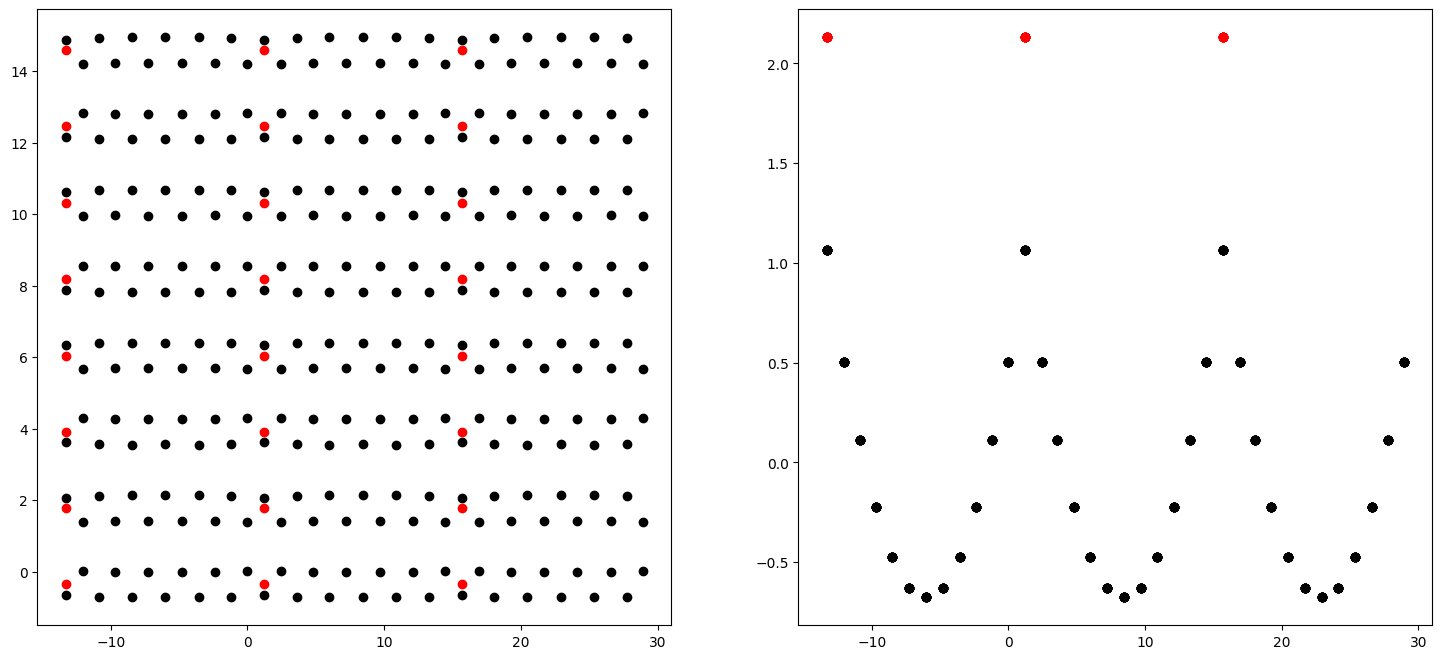

In [10]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,8))
for at in positions:
    if at[0] == 'C': color = 'black'
    if at[0] == 'H': color = 'red'
    ax[0].scatter(at[1],at[2],color=color)
for at in positions:
    if at[0] == 'C': color = 'black'
    if at[0] == 'H': color = 'red'
    ax[1].scatter(at[1],at[3],color=color)


## GS analysis

In [85]:
run_dir = 'DFT_analysis'

We use the input file 'Input_scf/qe_scf.in' as starting point for the DFT analysis

In [87]:
inp = I.PwInput(file='Input_scf/qe_scf.in')
inp.set_scf(force_symmorphic=True,conv_thr=1e-7)
inp.set_pseudo_dir('../../pseudos')
inp.add_atom(atom='C',pseudo_name='C_ONCV_PBE.upf',mass=12.011)
inp.add_atom(atom='H',pseudo_name='H_ONCV_PBE.upf',mass=1.0)
inp.set_num_bnds(100)
#inp

We observe that for this system the ratio between the x and y lenght of the unit cell is

In [27]:
14.4/4.26

3.3802816901408455

so we expect that, in general, an appropriate k-point sampling will respect this (reverse) ratio, so we choose sampling
of the type kx3k, that is 4x12,6x18,7x21 and so on. 

We perform a convergence analysis for the optimal sampling of the GS, using the total energy and the direct gap as controlo parameters.

In [53]:
kvalues = [4,5,6,7,8]

study = D.Dataset(run_dir=run_dir,num_tasks=3)
study.set_postprocessing_function(PP.pw_parse_data)

for k in kvalues:
    idd = {'gs-kpoints':'%sx%s'%(k,3*k)}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,3*k,1])
    study.append_run(id=idd,input=inp,runner=code)

Initialize a Dataset with 3 parallel tasks


In [54]:
#study.ids

In [55]:
results = study.run()

Run the selection [0, 1, 2, 3, 4] with the parallel task_groups [[0, 1, 2], [3, 4]] 

Run the task [0, 1, 2] 
Skip the run ofSkip the run of  gs-kpoints_4x12gs-kpoints_5x15

Skip the run of gs-kpoints_6x18
Task [0, 1, 2] ended 
 
Run the task [3, 4] 
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core pw.x -inp gs-kpoints_8x24.in > gs-kpoints_8x24.log
slurm submit:  cd DFT_analysis ; sbatch job_gs-kpoints_8x24.sh
computation gs-kpoints_8x24 is running...
Skip the run of gs-kpoints_7x21
Submitted batch job 13991341
computation gs-kpoints_8x24 ended
Task [3, 4] ended 
 


In [56]:
energies = []
gap = []
for ind in range(len(kvalues)):
    energies.append(results[ind].get_energy())
    gap.append(results[ind].get_gap(verbose=False)['gap'])
energies,gap

([-3964.5223841513866,
  -3964.526060802432,
  -3964.5280652409815,
  -3964.528962887252,
  -3964.5295063161134],
 [0.0773435597567046,
  0.07788680301031559,
  0.07821616420188415,
  0.0784291006751624,
  0.07857322841450332])

Text(0, 0.5, 'gap')

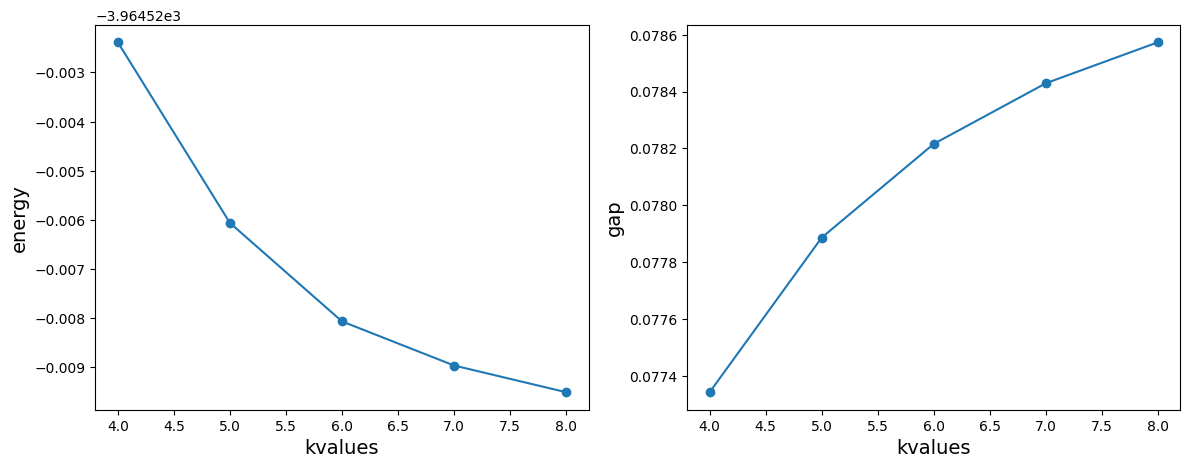

In [57]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5))
ax[0].plot(kvalues,energies)
ax[0].scatter(kvalues,energies)
ax[1].plot(kvalues,gap)
ax[1].scatter(kvalues,gap)
ax[0].set_xlabel('kvalues',size=14)
ax[0].set_ylabel('energy',size=14)
ax[1].set_xlabel('kvalues',size=14)
ax[1].set_ylabel('gap',size=14)

We obeserve that the numerical range is very limited so we can assume that converged GS is realized for the 5x15 k-grid

In [61]:
study = D.Dataset(run_dir=run_dir,num_tasks=1)

idd = 'gs_converged'
inp.set_prefix(D.name_from_id(idd))
inp.set_kpoints(points=[5,15,1])
study.append_run(id=idd,input=inp,runner=code)
study.set_postprocessing_function(PP.pw_parse_data)

Initialize a Dataset with 1 parallel tasks


In [62]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core pw.x -inp gs_converged.in > gs_converged.log
slurm submit:  cd DFT_analysis ; sbatch job_gs_converged.sh
computation gs_converged is running...
Submitted batch job 13991673
computation gs_converged ended
Task [0] ended 
 


In [63]:
results[0].get_gap()

Direct gap system
Gap : 0.07788680301031559 eV


{'gap': 0.07788680301031559,
 'direct_gap': 0.07788680301031559,
 'position_cbm': 0,
 'position_vbm': 0,
 'position_direct_gap': 0}

## Band structure on high symmetry line

Now we perform the bands computation specifying the kpoints on a path. 

To define the path we write the coordinates of the high symmetry points (using the tpiba_b or the crystal_b type of
pw) and we make usage of the function build_kpath

In [88]:
# cryst  coords
G_cryst = [0.0,0.0,0.0]
M2_cryst = [0.0,0.5,0.0]
K_cryst = [0.5,0.5,0.0]
M_cryst = [0.5,0.0,0.0]

We start from the definition of the high-sym point in crystal coordinates and compute their expression in cartesian coordinates

In [78]:
data = P.PwParser('DFT_analysis/gs_converged.save/data-file-schema.xml')
rec_lat = data.get_reciprocal_lattice(rescale=True)

Parse file : DFT_analysis/gs_converged.save/data-file-schema.xml


In [79]:
LL.convert_to_cartesian(rec_lat,M2_cryst)

array([-4.64076588e-07,  1.69466905e+00,  0.00000000e+00])

In [80]:
LL.convert_to_cartesian(rec_lat,K_cryst)

array([0.49999954, 1.69466867, 0.        ])

In [81]:
LL.convert_to_cartesian(rec_lat,M_cryst)

array([ 5.0000000e-01, -3.7915596e-07,  0.0000000e+00])

In [89]:
bands_prefix = 'bands'

# cartesian  coords
G = [0.0,0.0,0.0]
M2 = [0.0,1.694669,0.0]
K = [0.5,1.694669,0.0]
M = [0.5,0.0,0.0]

high_sym = {'G':G,'K':K,'M':M,'M2':M2} # useful to label the high-sym point on the path

In [95]:
klist = Tools.build_pw_kpath(G,M2,K,M,G,K,numstep=30)
klist

[[0.0, 0.0, 0.0, 30],
 [0.0, 1.694669, 0.0, 30],
 [0.5, 1.694669, 0.0, 30],
 [0.5, 0.0, 0.0, 30],
 [0.0, 0.0, 0.0, 30],
 [0.5, 1.694669, 0.0, 0]]

In [96]:
inp.set_bands(106,force_symmorphic=True,conv_thr=1e-7)
inp.set_prefix(bands_prefix)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'prefix': "'bands'",
  'outdir': "'./'",
  'restart_mode': "'from_scratch'",
  'wf_collect': '.true.',
  'pseudo_dir': "'../../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 0,
  'nat': 26,
  'ntyp': 2,
  'nbnd': 106,
  'ecutwfc': 70,
  'occupations': "'fixed'",
  'degauss': 0.0,
  'smearing': "'gaussian'"},
 'electrons': {'diago_full_acc': '.false.',
  'mixing_beta': 0.7,
  'conv_thr': 1e-07},
 'ions': {},
 'cell': {},
 'atomic_species': {'C': [12.011, 'C_ONCV_PBE.upf'],
  'H': [1.0, 'H_ONCV_PBE.upf']},
 'atomic_positions': {'type': 'angstrom',
  'values': [['C', [-0.0304453791, 0.0195298033, 0.5037486781]],
   ['C', [-0.0306962946, 1.4027710049, 0.5036492551]],
   ['C', [-1.179304419, -0.7075248433, 0.1140425637]],
   ['C', [-1.1788902431, 2.1297393804, 0.1141713108]],
   ['C', [-2.3626303648, -0.0004950151, -0.2237628217]],
   ['C', [-2.362967287, 1.4227025178, -0.2238398051]],
   ['C', [-3.573631809

In [97]:
results = code.run(input=inp,run_dir=run_dir,name=bands_prefix,source_dir='DFT_analysis/gs_converged.save')

delete folder: /leonardo_work/IscrC_ICE-SURF/AGSLn/n_6/DFT_analysis/bands.save
copy source_dir DFT_analysis/gs_converged.save in the /leonardo_work/IscrC_ICE-SURF/AGSLn/n_6/DFT_analysis/bands.save
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core pw.x -inp bands.in > bands.log
slurm submit:  cd DFT_analysis ; sbatch job_bands.sh
computation bands is running...
Submitted batch job 13993150
computation bands ended


Once that the computation is over we can create an instance of PwBands

In [98]:
bands = U.BandStructure.from_Pw(results,high_sym)

In [99]:
bands.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'K', 'M', 'M2'],
 [0.0,
  4.389337999999996,
  2.1946689999999984,
  6.156228777484839,
  3.8893379999999973,
  1.694669])

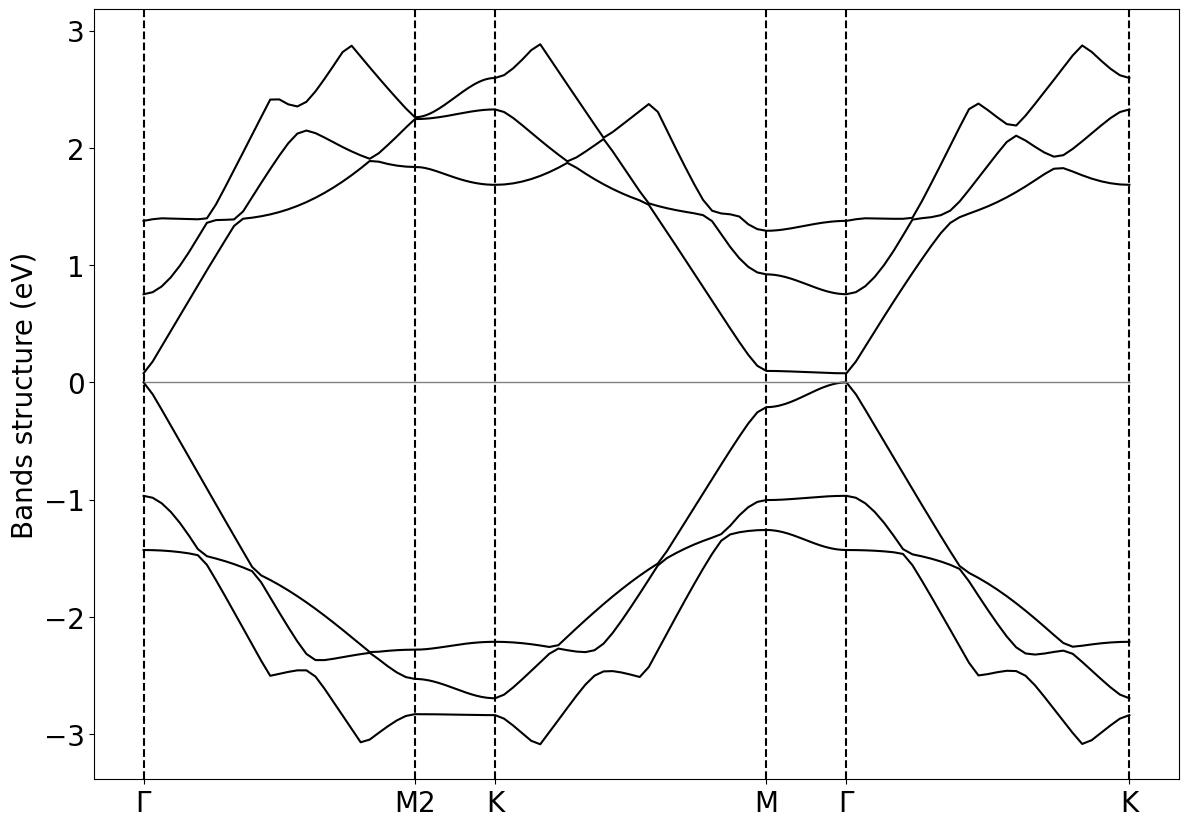

In [107]:
label_size = 20

fig, ax = plt.subplots(figsize=(14, 10))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(46,52)],color='black') #
#bands.plot(plt,selection=[i for i in range(26,30)],color='red')
ax.hlines(0.,0.,6.16,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

## NSCF computations on regular grids

We set up the nscf computations on regular grids.

In agreement with the strategy adopted for the GS we test k-point samplings of the type $k\times 3k\times 1$.

First we set the number of bands to 50, in this way we can perform the GW convergence at the HF level and we can also
compute the IP absorption spectrum testing its convergence in terms of the k-points samplings.

In [15]:
# cartesian  coords
G = [0.0,0.0,0.0]
M2 = [0.0,1.694669,0.0]
K = [0.5,1.694669,0.0]
M = [0.5,0.0,0.0]

In [16]:
nbnds = 50 #800 #500 #35
inp.set_nscf(nbnds,force_symmorphic=True,conv_thr=1e-6)
#inp

In [17]:
kvalues = [5,8,12] #[10,15,20,25,30]

In [18]:
study = D.Dataset(run_dir=run_dir,num_tasks=2)
study.set_postprocessing_function(PP.pw_parse_data)

for k in kvalues:
    idd = {'kpoints':'%sx%s'%(k,2*k),'nbnds':nbnds}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,2*k,1])
    study.append_run(id=idd,input=inp,runner=code,source_dir='DFT_analysis/gs_converged.save')

Initialize a Dataset with 2 parallel tasks


In [19]:
#study.runs[0]

In [20]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0, 1], [2]] 

Run the task [0, 1] 
Skip the run of kpoints_15x30-nbnds_600
The folder /leonardo_work/IscrC_ICE-SURF/AGSL5/DFT_analysis/kpoints_15x30-nbnds_600.save already exists. Source_dir DFT_analysis/gs_converged.save not copied
Skip the run of kpoints_20x40-nbnds_600
The folder /leonardo_work/IscrC_ICE-SURF/AGSL5/DFT_analysis/kpoints_20x40-nbnds_600.save already exists. Source_dir DFT_analysis/gs_converged.save not copied
Task [0, 1] ended 
 
Run the task [2] 
copy source_dir DFT_analysis/gs_converged.save in the /leonardo_work/IscrC_ICE-SURF/AGSL5/DFT_analysis/kpoints_25x50-nbnds_600.save
run command: mpirun -np 4 --map-by socket:PE=8 --rank-by core pw.x -inp kpoints_25x50-nbnds_600.in > kpoints_25x50-nbnds_600.log
slurm submit:  cd DFT_analysis ; sbatch job_kpoints_25x50-nbnds_600.sh
computation kpoints_25x50-nbnds_600 is running...
computation kpoints_25x50-nbnds_600 ended
Task [2] ended 
 


In [175]:
kp = results[1].kpoints # cartesian coordinates in units of 2\pi/alat

number of kpoints = 231


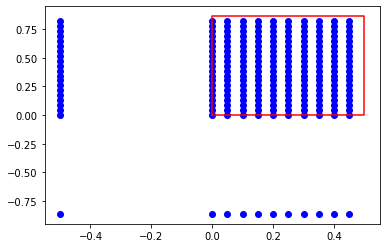

In [176]:
print('number of kpoints = %s'%len(kp))
IBZ = [G,M2,K,M,G]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kp[:,0],kp[:,1],c='blue')